Read ranking results

In [2]:
import pandas as pd
import numpy as np

shap_velo = dict()
shap_exp = dict()
interaction_weights = dict()

for tissue in ["Liver","Heart","Spleen","Kidney_Left","Large_Intestine","Lung_Right"]:
    shap_velo[tissue] = pd.read_csv("results/shap/shap-val-{}.csv".format(tissue), header = None)
    shap_velo[tissue].columns = ["target","tf","score","rep"]
    
    # compute normalized shap values
    dfs = []
    for (target,rep),df in shap_velo[tissue].groupby(["target","rep"]):
        df["score"] = df["score"]/df["score"].sum() * 100
        dfs.append(df)
    shap_velo[tissue] = pd.concat(dfs)
    
    # compute mean of normalize shap values across different runs
    df = shap_velo[tissue].groupby(["tf","target"])["score"].mean()
    interaction_weights[tissue] = pd.DataFrame({"tf":df.index.droplevel(1),
                                               "target":df.index.droplevel(0),
                                               "weight":df.values
                                               })

Read the list of all tf ensembl ids

In [3]:
tf_universe = pd.read_csv("data/raw/tf/tf_list.csv")["Ensembl ID"].values

Read ensmebl to gene name mapping

In [4]:
ensembl_to_symbol = pd.read_csv("data/raw/id_mapping/ensembl_to_symbol.csv", index_col = 0)
ensembl_to_symbol = ensembl_to_symbol.loc[~ensembl_to_symbol["ensembl_id"].duplicated(),:]

Read validation data downloaded from TF marker database

In [45]:
import pdb
from functools import reduce

tf_marker = pd.read_csv("data/processed/tfMarker/tfMarker_ensmebl.csv")
tissue_marker_genes = dict()
tissue_interactions = dict()
tf_marker.loc[tf_marker["tissue"] == "Kidney","tissue"] = "Kidney_Left"
tf_marker.loc[tf_marker["tissue"] == "Intestine","tissue"] = "Large_Intestine"
tf_marker.loc[tf_marker["tissue"] == "Lung","tissue"] = "Lung_Right"

# Keep only genes for the tested tissues
for tissue in ["Liver","Heart","Kidney_Left","Large_Intestine","Lung_Right"]:
    
    df = tf_marker.loc[tf_marker["tissue"] == tissue,]
        
    # Total TFs to be recovered for each tissue
    genes = reduce( 
                     np.intersect1d,
                     [np.unique(np.hstack([df["source_ensembl"].values,df["target_ensembl"].values])),
                      np.unique(shap_velo[tissue]["tf"].values),
                      tf_universe
                     ]
    )
    PMID = [tf_marker.loc[(tf_marker["tissue"] == tissue) & (tf_marker["source_ensembl"] == gene),"PMID"] for gene in genes]
    PMID = [";".join(pd.astype(str).unique()) for pd in PMID]
    tissue_marker_genes[tissue] = pd.DataFrame({"gene":genes, "PMID":PMID})
    
    # Count recoverable TF markers in each tissue
    print("{} has {} tissue-specific marker TFs".format(tissue,
                                                         tissue_marker_genes[tissue].shape[0]))

Liver has 48 tissue-specific marker TFs
Heart has 33 tissue-specific marker TFs
Kidney_Left has 59 tissue-specific marker TFs
Large_Intestine has 17 tissue-specific marker TFs
Lung_Right has 95 tissue-specific marker TFs


Get recall rate for each tissue and construct tissue-specific networks

In [20]:
from functools import reduce
def get_recall(df, tissue):
    
    # Get top 50 tf for each gene. Keep only the common tfs among the five reps
    el = []
    n_reps = 5
    for target,dff in df.groupby("target"):
        tfs = reduce(np.intersect1d, [dff.loc[dff["rep"] == rep,].iloc[:50,]["tf"] for rep in range(n_reps)])
        el.append(pd.DataFrame({'target':target, 'tf':tfs}))
    el = pd.concat(el)
    
    # Count the degree of each tf.
    tf_list = el["tf"].unique()
    
    counts = pd.DataFrame({"tf":tf_list,
                           "target_counts":np.zeros(tf_list.shape[0], dtype = np.int32)})
    for tf,df in el.groupby("tf"):
        counts.loc[counts["tf"] == tf,"target_counts"] = int(df.shape[0])

    # Rank tfs by degree counts
    counts = counts.sort_values(by = "target_counts", ascending = False)
    
    # Recall rate
    if tissue != "Spleen":
        recalled_tfs = np.intersect1d(tf_list, tissue_marker_genes[tissue]["gene"].values)
        num = recalled_tfs.shape[0]
        el["tf_is_marker"] = el["tf"].isin(recalled_tfs)
        return(el, recalled_tfs, num, tissue_marker_genes[tissue].shape[0], num/tissue_marker_genes[tissue].shape[0])
    else:
        num = 0
        el["tf_is_marker"] = "NA"
        return(el, np.array([]), 0, 0, 0)
    

rate_velo = pd.DataFrame(
    {
        'tissue':["Liver","Heart","Spleen","Kidney_Left","Large_Intestine","Lung_Right"],
        'recalled_num':[0,0,0,0,0,0],
        'total_num':[0,0,0,0,0,0],
        'rate':[0,0,0,0,0,0]
    }
)

tissue_networks = dict()
tissue_recalled_tfs = dict()
for tissue in ["Liver","Heart","Spleen","Kidney_Left","Large_Intestine","Lung_Right"]:
    
    el,recalled_tfs, recalled_num, total_num, rate = get_recall(shap_velo[tissue], tissue = tissue)
    rate_velo.loc[rate_velo["tissue"] == tissue, 'recalled_num'] = recalled_num 
    rate_velo.loc[rate_velo["tissue"] == tissue, 'total_num'] = total_num
    rate_velo.loc[rate_velo["tissue"] == tissue, 'rate'] = rate
    tissue_recalled_tfs[tissue] = recalled_tfs
    
    # Map ensmebl ids to gene names
    tf_symbol = el.loc[:,["tf","target"]].merge(
                                ensembl_to_symbol,
                                how = "left",
                                left_on = "tf",
                                right_on = "ensembl_id",
                               )["gene_symbol"]

    target_symbol = el.loc[:,["tf","target"]].merge(
                                    ensembl_to_symbol,
                                    how = "left",
                                    left_on = "target",
                                    right_on = "ensembl_id",
                                   )["gene_symbol"]
    
    tissue_networks[tissue] = pd.DataFrame({"tf_ensembl":el["tf"].values,
                 "target_ensembl":el["target"].values,
                 "tf_name":tf_symbol.values,
                 "target_name":target_symbol.values,
                "tf_is_marker":el["tf_is_marker"].values})
    
    # Assign edge weight
    tissue_networks[tissue]['weight'] = tissue_networks[tissue].merge(interaction_weights[tissue],
                                                                        how = "left",
                                                                        left_on = ["tf_ensembl","target_ensembl"],
                                                                        right_on = ["tf","target"]
                                                                     )['weight']

Compute recall rate for Random model

In [10]:
rate_random = pd.DataFrame(
    {
        'tissue':["Liver","Heart","Spleen","Kidney_Left","Large_Intestine","Lung_Right"],
        'recalled_num':[0,0,0,0,0,0],
        'total_num':[0,0,0,0,0,0],
        'rate':[0,0,0,0,0,0]
    }
)

for tissue in ["Liver","Heart","Spleen","Kidney_Left","Large_Intestine","Lung_Right"]:
    tf_list = shap_velo[tissue]["tf"].unique()
    rates = []
    num = []
    for i in range(1000):
        if tissue != "Spleen":
            selected = np.random.choice(tf_list, tissue_networks[tissue]["tf_ensembl"].unique().shape[0])
            num.append(np.intersect1d(selected, tissue_marker_genes[tissue]).shape[0])
            rates.append(num[-1]/tissue_marker_genes[tissue].shape[0])
        else:
            num.append(0)
            rates.append(0)
    
    if tissue != "Spleen":
        rate_random.loc[rate_random['tissue'] == tissue, 'recalled_num'] = np.mean(num)
        rate_random.loc[rate_random['tissue'] == tissue, 'total_num'] = tissue_marker_genes[tissue].shape[0]
        rate_random.loc[rate_random['tissue'] == tissue, 'rate'] = np.mean(rates)
    else:
        rate_random.loc[rate_random['tissue'] == tissue, 'recalled_num'] = np.mean(num)
        rate_random.loc[rate_random['tissue'] == tissue, 'total_num'] = 0
        rate_random.loc[rate_random['tissue'] == tissue, 'rate'] = np.mean(rates)

merge results

In [11]:
rate_velo["method"] = "MultiRank(RPKM + TFA -> velo)"
rate_random["method"] = "Random"
res = pd.concat([rate_velo,rate_random])

col1 = res["recalled_num"].tolist()
col2 = res["total_num"].tolist()
for i,val in enumerate(col1):
    if val % 1 == 0:
        col1[i] = np.int(val)
    if val % 1 != 0:
        col1[i] = np.round(val,2) # Round recalled number
res["bar_label"] = [str(c1) + "/" + str(c2) for c1,c2 in zip(col1, col2)]

/tmp/ipykernel_56243/4070561403.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col1[i] = np.int(val)


replace tissue labels

In [12]:
res["tissue"].loc[res["tissue"] == "Kidney_Left"] = "Left kidney"
res["tissue"].loc[res["tissue"] == "Lung_Right"] = "Right lung"
res["tissue"].loc[res["tissue"] == "Large_Intestine"] = "Large intestine"

# Remove spleen results
res = res.loc[res["tissue"] != "Spleen",]

/jet/home/qsong/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Compute the pvalues for the recall results

For each tissue

- k: the overlapping TF marker genes
- K: number of recoverable TF marker genes in each tissue
- n: number of TFs in the predicted network
- N: number of TFs in the input TF RPKM matrix


$P(X=k) = \frac{{K \choose k}{N-K \choose n-k}}{N \choose n}$

$P(X >= k) = \sum_{k}^{min(n,K)} \frac{{K \choose k}{N-K \choose n-k}}{N \choose n}$ 

pvalue = hypergeom.sf(k-1, N, K, n)

In [13]:
from scipy.stats import hypergeom
pvalues = []
for idx,row in res.iterrows():
    tissue = row["tissue"]
    k = row["recalled_num"]
    K = row["total_num"]
    n = tissue_networks['Liver']["tf_ensembl"].unique().shape[0]
    N = shap_velo['Liver']['tf'].unique().shape[0]
    pvalues.append(hypergeom.sf(k-1, N, K, n))

compute pvalue for the difference of recall rates for MTL vs random

In [14]:
from scipy.stats import ranksums

grp1 = res.loc[res["method"] == "MultiRank(RPKM + TFA -> velo)",]["rate"]
grp2 = res.loc[res["method"] == "Random",]["rate"]
p = ranksums(grp1, grp2).pvalue
print("p-value = {}".format(p))

p-value = 0.009023438818080326


Plot TF validation results

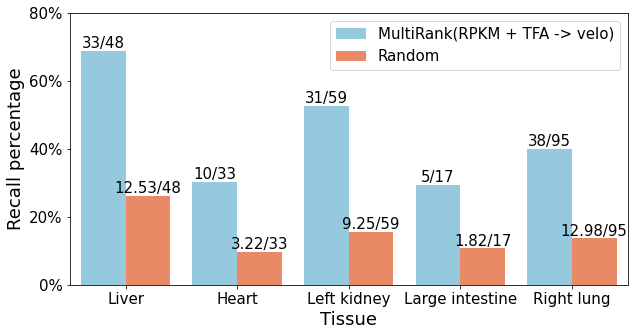

In [79]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Plot data
fig,axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
bp = sns.barplot(x="tissue",
                 y="rate",
                 hue = "method",
                 palette = {"MultiRank(RPKM + TFA -> velo)":"skyblue",
                            "Random":"coral"},
                 data = res,
                 capsize = 0.8,
                 ax = axs
                )
axs.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

for container,method in zip(bp.containers,res["method"].unique()):
    bp.bar_label(container, labels = res.loc[res["method"] == method,]["bar_label"].values, fontsize = 15)
    
axs.tick_params(axis = "both", labelsize = 15)
axs.set_xlabel("Tissue",{"fontsize":18})
axs.set_ylabel("Recall percentage",{"fontsize":18})
axs.set_title("", {"fontsize":15})
axs.set_yticks(ticks = [0,0.2,0.4,0.6,0.8])
axs.set_ylim((0,0.8))
axs.legend(fontsize = 15)
fig.show()

save tissue specific networks

In [23]:
for tissue,net in tissue_networks.items():
    net = net.sort_values(by = "tf_ensembl")
    net.to_csv("/results/network/network-{}.csv".format(tissue))

save tissue specific validated markers

In [60]:
import os
for tissue,net in tissue_networks.items():
    if tissue != "Spleen":
        file = "network/marker_table.xlsx"
        validate_marker_table = net.loc[net["tf_is_marker"],["tf_ensembl","tf_name"]].drop_duplicates()
        validate_marker_table = validate_marker_table.merge(tissue_marker_genes[tissue],
                                                            how = "left",
                                                            left_on = "tf_ensembl",
                                                            right_on = "gene"
                                                           ).loc[:, ["tf_ensembl","tf_name","PMID"]]
    else:
        validate_marker_table = pd.DataFrame({"tf_ensembl":[],"tf_name":[],"PMID":[]})
                                             
    # write to excel file
    if os.path.exists(file):
        with pd.ExcelWriter(file, mode = "a") as writer:
            validate_marker_table.to_excel(writer, sheet_name = tissue)
    else:
        with pd.ExcelWriter(file, mode = "w") as writer:
            validate_marker_table.to_excel(writer, sheet_name = tissue)